In [1]:
import pymc3 as pm
import sys
sys.path.append('..')
from src.utils import *
from src.params import *
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v5.csv',
        cols=['ppt_2021', 'hydraulic_c', 'median_hse', 'dem'], is_balanced=True)

/Users/juannat/Documents/research/septic/bayesian_septic/notebooks/../src/utils.py:76: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir)


balancing...
non-repairs: 27.73092578545258%, repairs: 72.26907421454743%


# Check Empirical Distribution

Precipitation

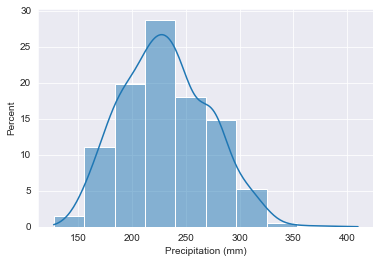

In [5]:
ax = sns.histplot(data=df, x='ppt_2021', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':3})
# ax.set_title('Distribution of Precipitation Annual Maxima in Georgia')
ax.set_xlabel('Precipitation (mm)')
plt.savefig('../docs/precip_dist.pdf', dpi=300)

Distance to water bodies

In [ ]:
ax = sns.histplot(data=df, x='water_dist', stat="percent", kde=True, kde_kws={'bw_adjust':3})
ax.set_title('Distance to Nearest Water Bodies (m) in Georgia')
ax.set_xlabel('Distance (m)')
ax.set_xlim([0,16000])
plt.savefig('../docs/wtr_dist.pdf', dpi=300)

Median Housing Values

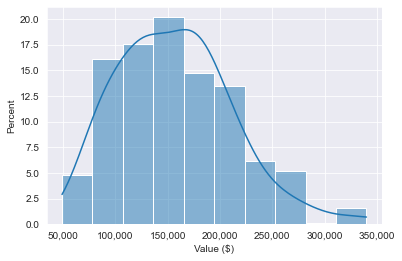

In [8]:
import matplotlib as mpl

ax = sns.histplot(data=df, x='median_hse', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':4})
# ax.set_title('Median Housing Value ($) in Georgia')
ax.set_xlabel('Value ($)')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../docs/hse_dist.pdf', dpi=300)

Soil Hydraulics

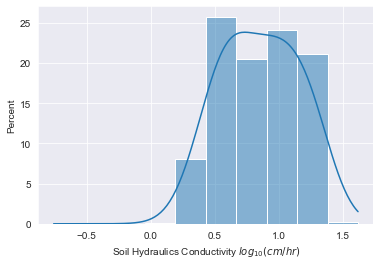

In [13]:
ax = sns.histplot(data=df, x='hydraulic_c', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':6})
# ax.set_title('Soil hydraulic conductivity in Georgia')
ax.set_xlabel('Soil Hydraulics Conductivity $log_{10}(cm/hr)$')
plt.savefig('../docs/hydr_dist.pdf', dpi=300)

DEM

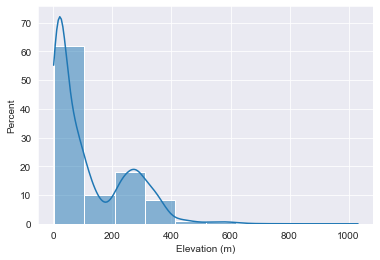

In [18]:
ax = sns.histplot(data=df, x='dem', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':2})
# ax.set_title('Digital Elevation (m) in Georgia')
ax.set_xlabel('Elevation (m)')
plt.savefig('../docs/dem_dist.pdf', dpi=300)

### Normalized Version

Precipitation

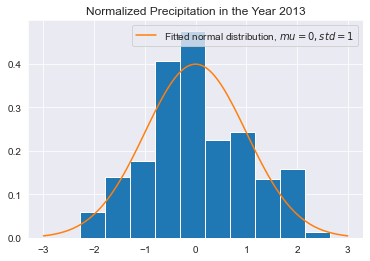

In [7]:
# plotting
x = np.linspace(-3,3,100)
y = stats.norm.pdf(x, loc=0., scale=1.)
df['ppt_2013_norm'].hist(density=True)
plt.title("Normalized Precipitation in the Year 2013")
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=1$")
plt.legend()

Distance to water bodies

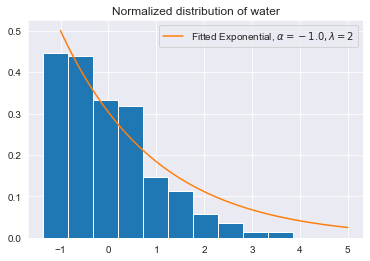

In [8]:
# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(-1,5,100)
y = stats.expon.pdf(x, loc=-1.,scale=2)
df['water_dist_norm'].hist(density=True)
plt.plot(x,y, label="Fitted Exponential, $\\alpha=-1.0, \lambda=2.$")
plt.title("Normalized distribution of water")
plt.legend()

Hydraulic Conductivity

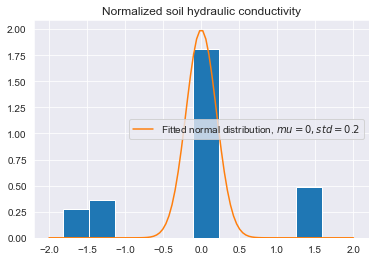

In [9]:
# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(-2,2,100)
y = stats.norm.pdf(x, loc=0., scale=0.2)
df['hydraulic_c_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=0.2$")
plt.title("Normalized soil hydraulic conductivity")
plt.legend()

Median housing values

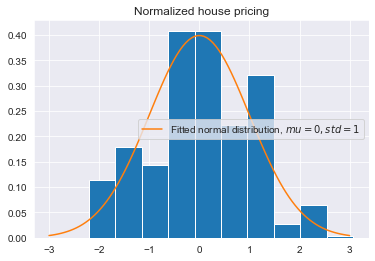

In [10]:
# plotting distribution (using Normal distribution)
x = np.linspace(-3,3,100)
y = stats.norm.pdf(x, loc=0, scale=1)
df['median_hse_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=1$")
plt.title("Normalized house pricing")
plt.legend()

DEM

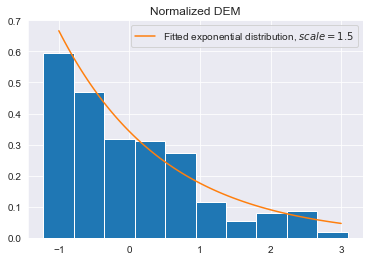

In [11]:
# plotting distribution (using Normal distribution)
x = np.linspace(-1,3,100)
y = stats.expon.pdf(x, loc=-1, scale=1.5)
df['dem_norm'].hist(density=True)
plt.plot(x,y, label="Fitted exponential distribution, $scale= 1.5$")
plt.title("Normalized DEM")
plt.legend()

# Wastewater EDA

In [3]:
df = pd.read_csv('../data/hierarchical_septics_v5.csv')

/var/folders/3_/bdv8r_590xz8hvrnflbd7dxm0000gn/T/ipykernel_11304/2214497231.py:1: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/hierarchical_septics_v5.csv')


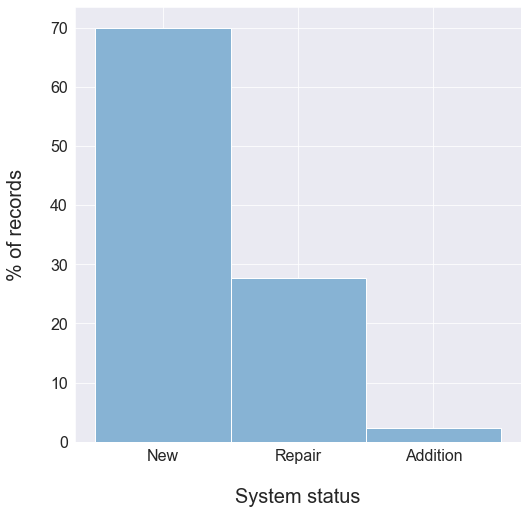

In [11]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='sewageSystem', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("System status", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('..//docs/percent_status.pdf', dpi=300, bbox_inches='tight')

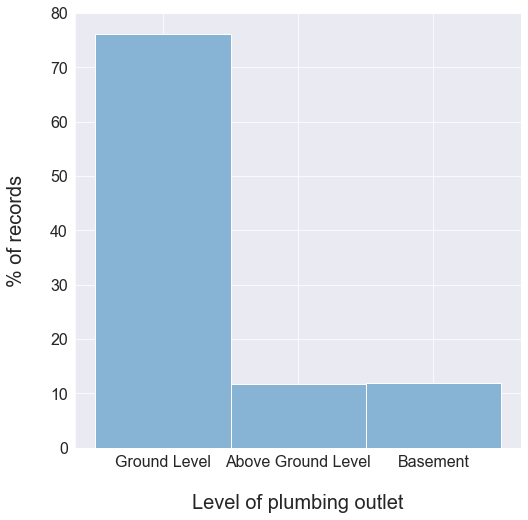

In [13]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='levelOfPlumbingOutlet', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Level of plumbing outlet", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('..//docs/percent_plumbing.pdf', dpi=300, bbox_inches='tight')

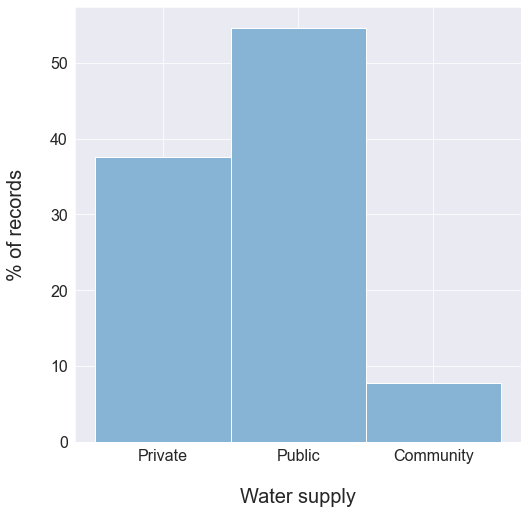

In [19]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df[df['waterSupply'] != '3'], x='waterSupply', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Water supply", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('..//docs/percent_watersupply.pdf', dpi=300, bbox_inches='tight')

Wastewater system distribution

In [7]:
bdry = gpd.read_file('../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
ga_bdry = bdry[bdry['STATEFP'] == '13']
ga_bdry.to_crs('EPSG:4326', inplace=True)

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))
gdf.set_crs('EPSG:4326', inplace=True)

,tblSGA_Property.gis_long_property,tblSGA_Property.gis_lat_property,tblSGA_Property.address_full_property,tblSGA_Property.county_property,waterSupply,typeOfStructure,waterUsageBy,noOfBedroomsGPD,percolationRateLoadingRate,soilSeries,...,HU_10_NAME,ppt_2021,dem,hydraulic_c,median_hse,sewageSystem_enc,ppt_2021_norm,hydraulic_c_norm,median_hse_norm,dem_norm
0,-81.265200,32.491200,"640 PORTER'S LANDING RD , CLYO, GA 31303",EFFINGHAM,Private,Single-Family Residence,Bedroom Numbers,4.0,10,Bonifay,...,Ebenezer Creek,239.722092,32.0,1.079826,163600.0,0,0.184702,0.745798,0.097579,-0.667543
1,-81.265200,32.491200,"620 PORTER'S LANDING RD , CLYO, GA 31303",EFFINGHAM,Private,Single-Family Residence,Bedroom Numbers,3.0,10,Bonifay,...,Ebenezer Creek,239.722092,32.0,1.079826,163600.0,0,0.184702,0.745798,0.097579,-0.667543
2,-81.269901,32.491267,"4503 N 119 HWY , CLYO, GA 31303",EFFINGHAM,Private,Single-Family Residence,Bedroom Numbers,3.0,10,NaN,...,Ebenezer Creek,239.722092,30.0,1.079826,163600.0,0,0.184702,0.745798,0.097579,-0.683405
3,-81.264149,32.492275,"357 REEDSVILLE RD , CLYO, GA 31303",EFFINGHAM,Private,Single-Family Residence,Bedroom Numbers,3.0,10,NaN,...,Ebenezer Creek,239.722092,27.0,1.079826,163600.0,0,0.184702,0.745798,0.097579,-0.707198
4,-81.263682,32.492758,"378 REEDSVILLE RD , CLYO, GA 31303",EFFINGHAM,Private,Single-Family Residence,Bedroom Numbers,3.0,10,NaN,...,Ebenezer Creek,239.722092,27.0,1.079826,163600.0,0,0.184702,0.745798,0.097579,-0.707198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111640,-84.864170,30.806857,"7870 PARKSIDE CIR , DONALSONVILLE, GA 39845",SEMINOLE,Private,Single-Family Residence,Bedroom Numbers,3.0,15.0,NaN,...,Fishpond Drain,314.862793,38.0,1.285724,81100.0,1,2.049556,1.439798,-1.455849,-0.619957
111641,-84.864170,30.806857,"7835 PARKSIDE CIR , DONALSONVILLE, GA 39845",SEMINOLE,Private,Single-Family Residence,Bedroom Numbers,2.0,15.0,NaN,...,Fishpond Drain,314.862793,38.0,1.285724,81100.0,1,2.049556,1.439798,-1.455849,-0.619957
111642,-84.864170,30.806857,"7882 PARKSIDE CIR , DONALSONVILLE, GA 39845",SEMINOLE,Private,Single-Family Residence,Bedroom Numbers,2.0,15.0,NaN,...,Fishpond Drain,314.862793,38.0,1.285724,81100.0,1,2.049556,1.439798,-1.455849,-0.619957
111643,-84.900265,30.809866,"3171 253 HWY , DONALSONVILLE, GA 39845",SEMINOLE,Private,Single-Family Residence,Bedroom Numbers,3.0,20.0,NaN,...,Chattahoochee River-Lake Seminole,305.408386,37.0,0.830894,81100.0,1,1.814915,-0.093252,-1.455849,-0.627888


In [8]:
# Spatial join
df_join = gpd.sjoin(ga_bdry, gdf) #Spatial join Points to polygons
df_join = pd.pivot_table(df_join, index='COUNTYFP', columns='sewageSystem', aggfunc={'sewageSystem':len})
df_join.columns = df_join.columns.droplevel()
df_join = ga_bdry.merge(df_join, how='left', on='COUNTYFP')
df_join['percent_repair'] = df_join['Repair'] / (df_join['Addition'] + df_join['Repair'] + df_join['New']) * 100

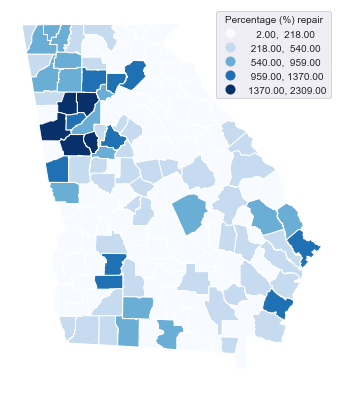

In [9]:
# Plotting
f, ax = plt.subplots(figsize=(7,7))
df_join.plot(
    column='Repair', 
    cmap='Blues', 
    scheme='natural_breaks', 
    legend=True, 
    ax=ax,
    legend_kwds={'title': 'Percentage (%) repair'}
)
ax.axis('off');
# f.savefig('./bayesian_septic/docs/spatial_repair.pdf', dpi=300, bbox_inches='tight')

<AxesSubplot:>

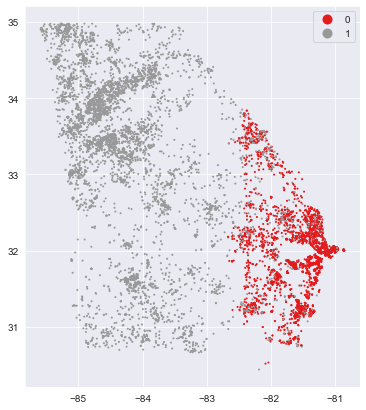

In [6]:
f, ax = plt.subplots(figsize=(7,7))
gdf.sample(n=12000).plot(column='sewageSystem_enc', categorical=True, cmap='Set1', markersize=1, legend=True, ax=ax)

In [47]:
df = pd.read_csv('../data/hierarchical_septics_v5.csv')

# encode categorical sewage system
enc, _ = pd.factorize(df['sewageSystem'])

/var/folders/3_/bdv8r_590xz8hvrnflbd7dxm0000gn/T/ipykernel_65148/1024170701.py:1: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/hierarchical_septics_v5.csv')


In [48]:
enc

array([0, 0, 0, ..., 1, 0, 1])

In [49]:
_

Index(['New', 'Repair', 'Addition'], dtype='object')